In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed_2/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import numpy.linalg as la
from scipy import stats

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import PooledOLS, compare

from linearmodels import IV2SLS

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
plt.rcParams['savefig.facecolor']='white'

In [3]:
data_path = os.path.join(output_filepath, 'panel_data.parquet')
df_model = pd.read_parquet(data_path)

df_model = df_model[df_model.year.between(1990, 2016)]

centralities = ['hubs', 'authorities','pagerank', 'gfi', 'bridging', 'favor']
centralities = ['hubs', 'authorities', 'bridging', 'favor']
centralities = ['hubs', 'authorities', 'favor']
networks = ['financial', 'goods', 'human']

#df_model = df_model[~df_model.country.isin(['ETH', 'BLR', 'ZWE', 'MDA', 'GUY', 'VNM', 'MAC', 'PSE', 'AGO', 'COD', 'TZA'])]

df_model.dropna(subset=['log_GFCF'], inplace=True)
df_model = df_model[(df_model.log_GFCF>0)&(df_model.log_gdp>0)&(~df_model.financial_hubs.isnull())]

df_model.eval('productivity = gdp*10**6/(wkn_population**0.3*GFCF**0.7)', inplace=True)
for c in [f'{n}_{c}' for c in centralities for n in networks] + ['productivity']:
    df_model[c] = df_model[c].map(lambda x: np.log1p(x*1.e8))

#df_model = df_model[df_model.wkn_population>5*1.e6]

all_terms_list = [f'{n}_{c}' for n in networks for c in centralities]
reduced_terms_list = all_terms_list.copy()
reduced_terms_list.remove('goods_favor')
reduced_terms_list.remove('financial_favor')
#reduced_terms_list.remove('human_bridging')

In [4]:
corr_cols = ['log_output', 'log_gdp', 'gini', 'log_GFCF', 'log_wkn_population'] + [f'{n}_{c}' for c in centralities for n in networks]

df_model[['country', 'year'] + corr_cols].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,693,63,PER,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,693,NaN,NaN,NaN,2010,3.16456,2005,2007,2010,2013,2015
log_output,693,NaN,NaN,NaN,13.1611,1.63172,9.2651,12.1621,13.1661,14.2926,17.2437
log_gdp,693,NaN,NaN,NaN,12.4528,1.64519,8.68912,11.4061,12.4565,13.6032,16.6869
gini,300,NaN,NaN,NaN,0.319593,0.0604838,0.234,0.26975,0.315,0.349,0.62
log_GFCF,693,NaN,NaN,NaN,24.8718,1.68266,20.8034,23.8554,24.8415,26.0618,29.1997
log_wkn_population,693,NaN,NaN,NaN,15.8962,1.75242,11.9892,14.8156,15.9243,17.0253,20.4807
financial_hubs,693,NaN,NaN,NaN,14.0345,0.533541,12.8298,13.6625,13.9762,14.3717,16.4159
goods_hubs,693,NaN,NaN,NaN,13.9914,0.581539,12.8074,13.5855,13.9208,14.3369,16.4432
human_hubs,693,NaN,NaN,NaN,11.5149,0.8924,9.26617,11.0424,11.4313,12.0875,13.7539


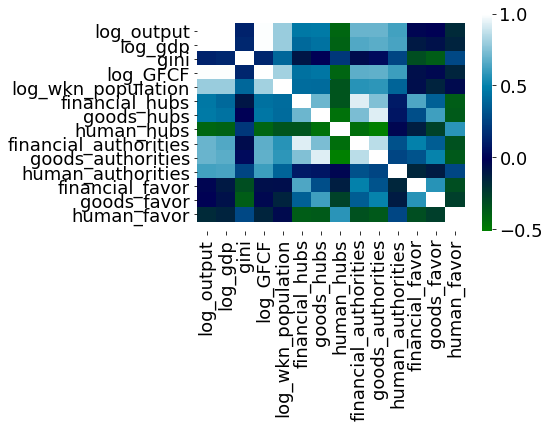

In [5]:
plt.rcParams.update({'font.size': 18})

corr = df_model[corr_cols].corr()

# plot the heatmap
sns.heatmap(corr, cmap="ocean",
        xticklabels=corr.columns,
        yticklabels=corr.columns,)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.7 # Add 0.5 to the bottom
t -= 0.7 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

## Variable selection
Some of the social capital variables we want to include are highly correlated --> need to reduce dimensionality in order to avoid multicolinearity


In [6]:
from scipy.stats import pearsonr
import statsmodels.api as sm

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""

    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.5, .1), xycoords=ax.transAxes)

def r2func(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""

    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    r2 = results.rsquared

    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    ax.annotate(f'$R^2$= {r2:.2f}', xy=(.5, .1), xycoords=ax.transAxes)

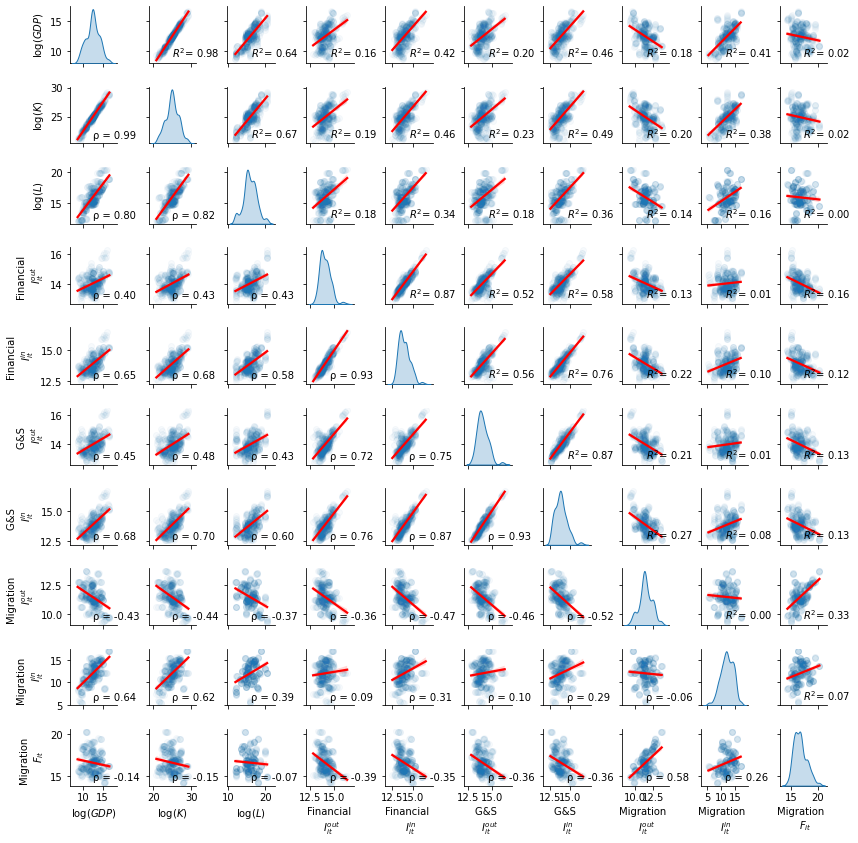

In [7]:
plt.rcParams.update({'font.size': 10})

variables = ['log_gdp', 'log_GFCF', 'log_wkn_population'] + reduced_terms_list
names = ['$\log(GDP)$', '$\log(K)$', '$\log(L)$',
         'Financial \n $I_{it}^{out}$', 'Financial \n $I_{it}^{in}$',
         'G&S \n $I_{it}^{out}$', 'G&S \n $I_{it}^{in}$',
         'Migration  \n $I_{it}^{out}$', 'Migration  \n $I_{it}^{in}$', 'Migration  \n $F_{it}$']

g = sns.pairplot(df_model[variables].sample(500), 
                 kind='reg', 
                 diag_kind = 'kde', 
                 plot_kws={'scatter_kws': {'alpha': 0.03}, 
                 'line_kws':{'color':'red'}})
g.fig.set_size_inches(12,12)

g.map_upper(r2func)
plt.rcParams.update({'font.size': 10})
g.map_lower(corrfunc)

names_dict = dict(zip(variables, names))

plt.rcParams.update({'font.size': 16})
for i in range(len(variables)):
    for j in range(len(variables)):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in names_dict.keys():
            g.axes[i][j].set_xlabel(names_dict[xlabel])
        if ylabel in names_dict.keys():
            g.axes[i][j].set_ylabel(names_dict[ylabel])

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'social_capital_multicolinearity.png')
plt.savefig(save_to)    
plt.show()

## Stacked results

In [8]:
def stacked_results(y_label, 
                    social_capital_terms = [f'{n}_{c}' for c in centralities for n in networks],
                    estimator = PanelOLS):

    var_list = ' + '.join(social_capital_terms)
    f = f'{y_label} ~ {var_list} + log_GFCF + log_wkn_population + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    
    model = PanelOLS(y,X, entity_effects=True, time_effects=True)
    #model = RandomEffects(y,X)
    #model = PooledOLS(y,X)
    results_combined_model = model.fit()

    df_results = pd.DataFrame(results_combined_model.params).reset_index()
    df_results['pvalues'] = results_combined_model.pvalues.values
    df_results['show_value'] = df_results.apply(lambda x: f'{round(x.parameter,4)} ({round(x.pvalues, 5)})', axis=1)
    df_results = df_results[~df_results['index'].isin(['Intercept','log_GFCF','log_wkn_population'])]
    df_results['network'], df_results['capital'] = zip(*df_results['index'].map(lambda x: (x.split('_')[-2], x.split('_')[-1])))
    print(f'''Results regression analysis: {y_label} ''')
    df_results = df_results.pivot_table(index='network', columns = 'capital', values = 'show_value', aggfunc=lambda x: x)
    
    return df_results

In [9]:
stacked_results('log_gdp', social_capital_terms=reduced_terms_list)

Results regression analysis: log_gdp 


capital,authorities,favor,hubs
network,,,
financial,0.55 (0.0),NaN,-0.6815 (0.0)
goods,-0.1575 (0.18205),NaN,0.3078 (0.00545)
human,-0.0847 (6e-05),-0.0852 (0.16805),0.2367 (1e-05)


In [10]:
stacked_results('gini', social_capital_terms=reduced_terms_list)

Results regression analysis: gini 


capital,authorities,favor,hubs
network,,,
financial,-0.0493 (0.09831),NaN,0.0279 (0.33729)
goods,-0.0016 (0.95494),NaN,-0.0101 (0.72113)
human,0.0135 (0.03396),-0.0738 (0.00087),0.0137 (0.40314)


## One variable models

In [11]:
models = []

f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
#f = f'productivity ~ 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
base_model_fe = base_model_fe.fit()

models.append(base_model_fe)
    
for v in reduced_terms_list:

    f = f'log_gdp ~ log_GFCF + log_wkn_population + {v} + 1'
    #f = f'productivity ~ {v} + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
    base_model_fe = base_model_fe.fit()
    
    models.append(base_model_fe)
    

c = compare(dict(zip(['base model'] + reduced_terms_list, models)), precision='pvalues', stars=True)
#print(c.summary.as_latex())
c.summary

,base model,financial_hubs,financial_authorities,goods_hubs,goods_authorities,human_hubs,human_authorities,human_favor
Dep. Variable,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,693,693,693,693,693,693,693,693
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted
R-squared,0.6952,0.6973,0.6952,0.7040,0.7054,0.7021,0.6977,0.6965
R-Squared (Within),0.6799,0.6905,0.6811,0.6780,0.6703,0.7223,0.6753,0.6914
R-Squared (Between),0.7659,0.7749,0.7664,0.7956,0.7973,0.7866,0.7461,0.7905
R-Squared (Overall),0.7643,0.7733,0.7648,0.7934,0.7950,0.7854,0.7447,0.7886
F-statistic,704.71,473.85,469.10,489.22,492.49,484.61,474.65,472.04
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## FULL MODEL COMPARISON

In [12]:
def adj_rsquared(model):
    adj_rsquared = 1 - (model.nobs-1)/model.df_resid * (1-model.rsquared)
    return adj_rsquared

In [13]:
reduced_terms_regression = ' + '.join(reduced_terms_list)

In [14]:
# Base model
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model = PooledOLS(y,X)
base_model_hac = base_model.fit(cov_type="kernel")
base_model = base_model.fit()

f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model_re = RandomEffects(y,X)
base_model_re_hac = base_model_re.fit(cov_type="kernel")
base_model_re = base_model_re.fit()

f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
base_model_fe_hac = base_model_fe.fit(cov_type="kernel")
base_model_fe = base_model_fe.fit()

# Extended model
f = f'log_gdp ~ {reduced_terms_regression} +  log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model = PooledOLS(y,X)
extended_model_hac = extended_model.fit(cov_type="kernel")
extended_model = extended_model.fit()

f = f'log_gdp ~ {reduced_terms_regression} +  log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model_re = RandomEffects(y,X)
extended_model_re_hac = extended_model_re.fit(cov_type="kernel")
extended_model_re = extended_model_re.fit()

f = f'log_gdp ~ {reduced_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
extended_model_fe = PanelOLS(y,X, entity_effects=True, time_effects=True)
extended_model_fe_hac = extended_model_fe.fit(cov_type="kernel")
extended_model_fe = extended_model_fe.fit()

model_dict = {'Base Model':base_model,
              'Base Mode HAC':base_model_hac,
             'Extended Model':extended_model,
             'Extended Model HAC':extended_model_hac,
             'Base Model Random Effects':base_model_re,
             'Base Model Random Effects HAC':base_model_re_hac,
             'Base Model Fixed Effects':base_model_fe,
             'Base Model Fixed Effects HAC':base_model_fe_hac,
             'Extended Model Random Effects':extended_model_re,
             'Extended Model Random Effects HAC':extended_model_re_hac,
             'Extended Model Fixed Effects':extended_model_fe,
             'Extended Model Fixed Effects HAC':extended_model_fe_hac,
             }
c = compare(model_dict, precision='std_errors', stars=True, )
#print(c.summary.as_latex())
c.summary

,Base Model,Base Mode HAC,Extended Model,Extended Model HAC,Base Model Random Effects,Base Model Random Effects HAC,Base Model Fixed Effects,Base Model Fixed Effects HAC,Extended Model Random Effects,Extended Model Random Effects HAC,Extended Model Fixed Effects,Extended Model Fixed Effects HAC
Dep. Variable,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp,log_gdp
Estimator,PooledOLS,PooledOLS,PooledOLS,PooledOLS,RandomEffects,RandomEffects,PanelOLS,PanelOLS,RandomEffects,RandomEffects,PanelOLS,PanelOLS
No. Observations,693,693,693,693,693,693,693,693,693,693,693,693
Cov. Est.,Unadjusted,Driscoll-Kraay,Unadjusted,Driscoll-Kraay,Unadjusted,Driscoll-Kraay,Unadjusted,Driscoll-Kraay,Unadjusted,Driscoll-Kraay,Unadjusted,Driscoll-Kraay
R-squared,0.9815,0.9815,0.9843,0.9843,0.8894,0.8894,0.6952,0.6952,0.8953,0.8953,0.7398,0.7398
R-Squared (Within),0.5791,0.5791,0.6685,0.6685,0.7201,0.7201,0.6799,0.6799,0.7764,0.7764,0.7297,0.7297
R-Squared (Between),0.9891,0.9891,0.9903,0.9903,0.9690,0.9690,0.7659,0.7659,0.9736,0.9736,0.8100,0.8100
R-Squared (Overall),0.9815,0.9815,0.9843,0.9843,0.9644,0.9644,0.7643,0.7643,0.9699,0.9699,0.8085,0.8085
F-statistic,1.826e+04,1.826e+04,4755.5,4755.5,2775.5,2775.5,704.71,704.71,648.92,648.92,193.05,193.05
P-value (F-stat),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [15]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt


df_extra = pd.DataFrame({'Model':[k for k,v in model_dict.items()],
                         'Adj-r2':[adj_rsquared(v) for k,v in model_dict.items()],
                         'nobs':[v.nobs for k,v in model_dict.items()],
                         'DW':[durbin_watson(v.resids) for k,v in model_dict.items()],
                         'BP':[het_breuschpagan(v.resids, v.model.exog.dataframe.values)[1] for k,v in model_dict.items()],
                         'GQ':[het_goldfeldquandt(v.resids, v.model.exog.dataframe.values)[1] for k,v in model_dict.items()]})
df_extra

,Model,Adj-r2,nobs,DW,BP,GQ
0,Base Model,0.981407,693,0.393317,3.447650e-03,0.999910
1,Base Mode HAC,0.981407,693,0.393317,3.447650e-03,0.999910
2,Extended Model,0.984086,693,0.382155,1.714374e-11,0.544291
3,Extended Model HAC,0.984086,693,0.382155,1.714374e-11,0.544291
4,Base Model Random Effects,0.889120,693,0.591422,1.336564e-14,0.999994
5,Base Model Random Effects HAC,0.889120,693,0.591422,1.336564e-14,0.999994
6,Base Model Fixed Effects,0.658681,693,0.810908,1.117598e-04,0.998957
7,Base Model Fixed Effects HAC,0.658681,693,0.810908,1.117598e-04,0.998957
8,Extended Model Random Effects,0.893919,693,0.577106,9.847281e-18,0.999563
9,Extended Model Random Effects HAC,0.893919,693,0.577106,9.847281e-18,0.999563


In [16]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1.e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 

    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(extended_model_fe, extended_model_re) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: -189.0620991712142
degrees of freedom: 10
p-Value: 1.0


Pvalue < 0.05 we reject the null that random effects are consistent.

## VIF

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df_model[['log_GFCF', 'log_wkn_population'] + reduced_terms_list].values, i) for i in range(len(reduced_terms_list )+2)]

print(list(zip(['log_GFCF', 'log_wkn_population'] + reduced_terms_list, vif)))

[('log_GFCF', 1302.3438221089684), ('log_wkn_population', 273.22129265813396), ('financial_hubs', 18428.43841586562), ('financial_authorities', 22573.523712710245), ('goods_hubs', 12807.362769530606), ('goods_authorities', 16564.644976176645), ('human_hubs', 349.99525206877456), ('human_authorities', 71.21373614339525), ('human_favor', 326.8821672499318)]


## Lasso

In [18]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'alpha': np.arange(0.1,0.9,0.1), 
   'l1_ratio': np.arange(0.1,0.9,0.1),
   'fit_intercept':[True],
   'normalize': [True],
   'selection':['cyclic', 'random'],
   'max_iter':[10000]}]


X = df_model[reduced_terms_list + ['log_GFCF', 'log_wkn_population']].values
y = df_model[['log_gdp']].values

reg = GridSearchCV(
        ElasticNet(), param_grid)
reg.fit(X, y)
    

print(reg.best_estimator_.alpha)

print(reg.best_estimator_.intercept_)

pd.DataFrame({'variable':reduced_terms_list + ['log_GFCF', 'log_wkn_population'], 
              'coefficient':reg.best_estimator_.coef_}).sort_values(by='coefficient', ascending=False)

0.1
[11.21505922]


,variable,coefficient
1,financial_authorities,0.017926
3,goods_authorities,0.017150
7,log_GFCF,0.012394
2,goods_hubs,0.011218
0,financial_hubs,0.010676
8,log_wkn_population,0.009054
5,human_authorities,0.005343
6,human_favor,-0.000000
4,human_hubs,-0.006292


## PCA variables

Text(0, 0.5, 'cumulative explained variance')

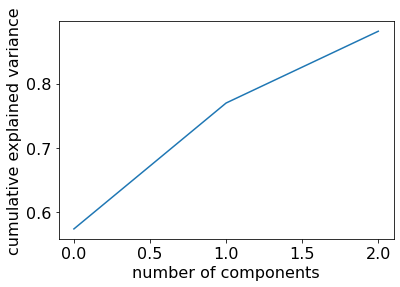

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n = 3

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[reduced_terms_list])

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[reduced_terms_list])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [20]:
f = 'log_gdp ~ log_GFCF + log_wkn_population + 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
#f = 'productivity ~ 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = PanelOLS(y,X, entity_effects=True, time_effects=True)
model = RandomEffects(y,X)
results = model.fit()
results.summary

Dep. Variable:,log_gdp,R-squared:,0.8904
Estimator:,RandomEffects,R-squared (Between):,0.9747
No. Observations:,693,R-squared (Within):,0.7313
Date:,"Wed, Dec 15 2021",R-squared (Overall):,0.9701
Time:,09:52:45,Log-likelihood,449.72
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1116.1
Entities:,63,P-value,0.0000
Avg Obs:,11.000,Distribution:,"F(5,687)"
Min Obs:,11.000,,
Max Obs:,11.000,F-statistic (robust):,1116.1


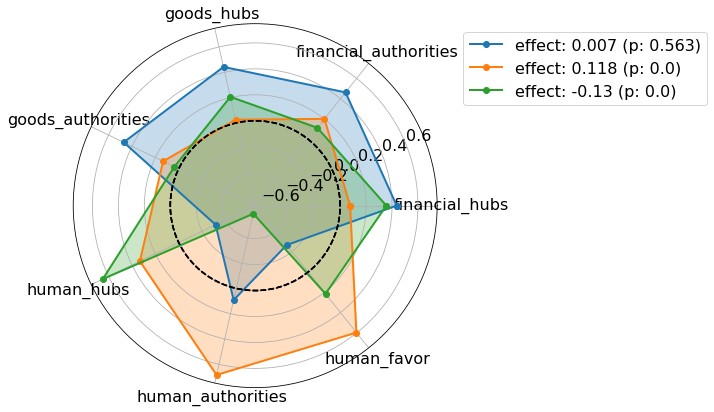

In [21]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = reduced_terms_list)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = reduced_terms_list.copy()
stats_vector = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(reduced_terms_list), endpoint=False)
circle_angles = np.linspace(0, 2*np.pi, 1000, endpoint=True)

fig=plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats_vector = df_radar.loc[i,reduced_terms_list]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats_vector,[stats_vector[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
    )
    ax.fill(angles, stats_vector, alpha=0.25)
    ax.plot(circle_angles, np.zeros_like(circle_angles), 'k--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'pca_results.png')
plt.savefig(save_to, transparent=False)    
plt.show()

## Time series

In [22]:
delta_reduced_terms_list = ['delta_' + c for c in reduced_terms_list] 

In [23]:
model = IV2SLS(df_model.delta_log_gdp, df_model[reduced_terms_list + ['constant']], df_model.lag_log_gdp, df_model.lag_log2_gdp)
results = model.fit()
results.summary

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          delta_log_gdp   R-squared:                      0.0511
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0375
No. Observations:                 567   F-statistic:                    32.753
Date:                Wed, Dec 15 2021   P-value (F-stat)                0.0001
Time:                        09:52:46   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
financial_hubs           -0.0374     0.0534    -0.6997     0.4841     -0.1420      0.0673
financial_authorities     0.0523     0.0583     0.8971     0.3697     -0.0620      0.1667
goods_hubs                0.0093     0.0455     0.2050     0.8376     -0.0798      0.0984
goods_authorities         0.0243     0.0517     0.4696     0.6386     -0.0771      0.1256
human_hubs               -0.0107     0.0079    -1.3457     0.1784     -0.0262      0.0049
human_authorities         0.0011     0.0031     0.3671     0.7135     -0.0050      0.0072
human_favor               0.0104     0.0058     1.7883     0.0737     -0.0010      0.0218
constant                 -0.3734     0.2560    -1.4587     0.1446     -0.8750      0.1283
lag_log_gdp              -0.0257     0.0078    -3.2806     0.0010     -0.0411     -0.0104
=========================================================================================

Endogenous: lag_log_gdp
Instruments: lag_log2_gdp
Robust Covariance (Heteroskedastic)
Debiased: False
"""

### Time series PCA 

In [24]:
f = 'delta_log_gdp ~ delta_log_GFCF + delta_log_wkn_population + 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
#f = 'productivity ~ 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = PanelOLS(y,X, entity_effects=True, time_effects=True)
model = RandomEffects(y,X)
results = model.fit()
results.summary

Dep. Variable:,delta_log_gdp,R-squared:,0.6926
Estimator:,RandomEffects,R-squared (Between):,0.7333
No. Observations:,630,R-squared (Within):,0.6882
Date:,"Wed, Dec 15 2021",R-squared (Overall):,0.6926
Time:,09:52:46,Log-likelihood,831.26
Cov. Estimator:,Unadjusted,,
,,F-statistic:,281.24
Entities:,63,P-value,0.0000
Avg Obs:,10.0000,Distribution:,"F(5,624)"
Min Obs:,10.0000,,
Max Obs:,10.0000,F-statistic (robust):,281.24


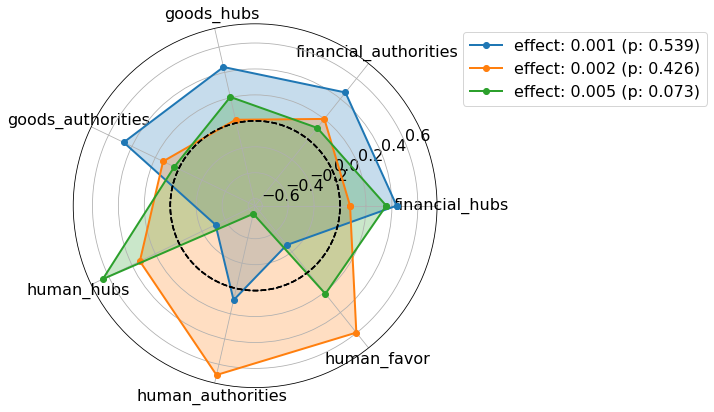

In [25]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = reduced_terms_list)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = reduced_terms_list.copy()
stats_vector = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(reduced_terms_list), endpoint=False)
circle_angles = np.linspace(0, 2*np.pi, 1000, endpoint=True)

fig=plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats_vector = df_radar.loc[i,reduced_terms_list]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats_vector,[stats_vector[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
    )
    ax.fill(angles, stats_vector, alpha=0.25)
    ax.plot(circle_angles, np.zeros_like(circle_angles), 'k--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

plt.tight_layout()
save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'delta_pca_results.png')
plt.savefig(save_to, transparent=False)    
plt.show()